#Workshop 4 - Cluster Weak Lensing Analysis

Shear catalog and Python script are provided by Dr. Masamune Oguri (RESCEU & Kavli IPMU, The University of Tokyo)

Modified by Dr. Anton T. Jaelani in many parts, especially in NFW part

Main references:

1. Oguri, M. et al., "Combined strong and weak lensing analysis of 28 clusters from the Sloan Giant Arcs Survey", [2012, MNRAS, 420, 4](https://academic.oup.com/mnras/article/420/4/3213/973116) -- [arXiv:1109.2594](https://arxiv.org/abs/1109.2594v2)

2. Bartelmann, M. & Schneider, P., "Weak Gravitational Lensing", [2001, Physics Reports, 340, 4 - 5](https://www.sciencedirect.com/science/article/pii/S037015730000082X?via%3Dihub) -- [arXiv:astro-ph/9912508](https://arxiv.org/abs/astro-ph/9912508v1)

3. Bartelmann, M. & Maturi, M., "Weak gravitational lensing", 2016 -- [arXiv:1612.06535](https://arxiv.org/abs/1612.06535v1)

4. Lecture on "Introduction to Weak Gravitational Lensing" by Dr. Masamune Oguri.

At the end of this workshop you’ll be able to calculate the tangential and cross shear from weak lensing shear catalog. Furthermore, you will learn how to analyze cluster weak lensing based on tangential shear in order to extract information on dark matter distribution such as total mass.

In [ ]:
# [Cell 1]
#Python packages you need
import numpy as np
from astropy import wcs
from scipy.optimize import curve_fit, brentq
from astropy import constants as const
from astropy import units as u
from astropy.cosmology import FLRW, FlatLambdaCDM, Flatw0waCDM, FlatwCDM, LambdaCDM, w0waCDM, w0wzCDM, wCDM, wpwaCDM
from numpy.lib import scimath as sm
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter, AutoMinorLocator
from matplotlib.ticker import StrMethodFormatter, NullFormatter
from google.colab import files

%matplotlib inline
mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.size'] = 22
mpl.rcParams['legend.handlelength'] = 3.0
mpl.rcParams['axes.linewidth'] = 1.0
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['xtick.major.width'] = 1.0
mpl.rcParams['xtick.minor.width'] = 1.0
mpl.rcParams['xtick.major.size'] = 5.0
mpl.rcParams['xtick.minor.size'] = 3.0
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['ytick.major.width'] = 1.0
mpl.rcParams['ytick.minor.width'] = 1.0
mpl.rcParams['ytick.major.size'] = 5.0
mpl.rcParams['ytick.minor.size'] = 3.0
mpl.rcParams['ytick.right'] = True

plt.rcParams['ps.useafm'] = True
#######optional
#plt.rcParams['pdf.use14corefonts'] = True
#plt.rcParams['text.usetex'] = True
#plt.rcParams['text.latex.preamble'] = '\\usepackage{sfmath}'
#!apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng

**Read File**


In [ ]:
# [Cell 2]
# Set cosmological parameters (e.g., Flat Universe LambdaCDM)
cosmo = FlatLambdaCDM(H0 = 70.2, Om0 = 0.275)   # from Oguri et al. 2012

# Name of the cluster used in the filename (e.g., sdss1138)
cname   = "sdss1138"

# cluster redshift
zl      = 0.451

# Coordinates of the cluster center
ra_cl   = 174.537292
dec_cl  = 27.908528

# Fix source redshift by using the source redshift assumption from Oguri et al. 2012
zs =

##############################
# Read shear file
# Please download the shear catalog from this link https://drive.google.com/drive/folders/1QJtxeGn0lOXRuNbAS7fGu7-9k1rEgaeq?usp=sharing
data_to_load = files.upload()

# See browse button below when you are running this cell!

rfile = 'shear_' + cname + '.dat'
data = np.loadtxt(rfile, comments = '#')

ra  = data[:, 0]
dec = data[:, 1]
g1  = data[:, 2]
g2  = data[:, 3]
wei = data[:, 4]

# First convert RA and Dec to flat sky coordinate
dx = -1.0 / 60.0
dy =  1.0 / 60.0

w = wcs.WCS(naxis = 2)

w.wcs.crval = [ra_cl, dec_cl]
w.wcs.cd    = np.array([[dx, 0.0], [0.0, dy]])
w.wcs.ctype = ["RA---TAN", "DEC--TAN"]
w.wcs.crpix = [0, 0]

coord = np.stack([ra, dec], axis = 1)

xy = w.wcs_world2pix(coord, 1)

# Write coordinate-converted catalog to a file
ofile = 'shear_' + cname + '_xy.dat'

f1 = open(ofile, 'w')

x = xy[:,0]
y = xy[:,1]

for i in range(len(wei)):
   f1.write('%f ' %(x[i]))
   f1.write('%f ' %(y[i]))
   f1.write('%f ' %(g1[i]))
   f1.write('%f ' %(g2[i]))
   f1.write('%f ' %(wei[i]))
   f1.write('\n')

f1.close()
# Please remove a hash mark (#) below if you want to save coordinate-converted catalog into a .dat file
#files.download(ofile)

Saving shear_sdss1138.dat to shear_sdss1138.dat


**The shear**


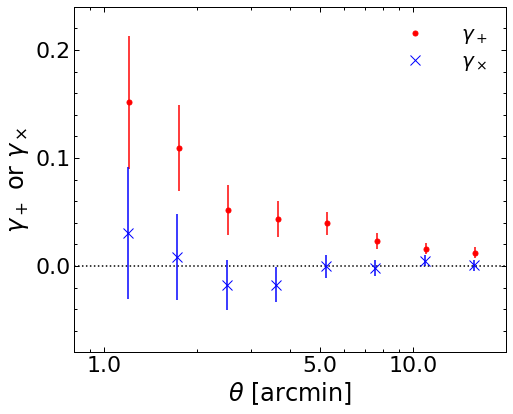

In [ ]:
# [Cell 3]
##############################
# Definition of annulus i.e., theta bin
# it is equally spaced in log10 between 10 ** ltmin and 10 ** ltmax
# You can modify the annulus radii here
ltmin  =  0.0
ltmax  =  1.28
dlt    =  0.16

nbin = int((ltmax - ltmin + 1.0e-30) / dlt)

lt1 = np.linspace(ltmin, ltmax - dlt, num = nbin)
lt2 = np.linspace(ltmin + dlt, ltmax, num = nbin)

tbin = 10 ** (0.5 * (lt1 + lt2))

##############################
# Compute theta in each bin
t  = np.sqrt(x * x + y * y)
lt = np.log10(t)

##############################
# Compute tangential and cross shear following the definition

cos2 = (x * x - y * y) / (t * t + 1.0e-30)
sin2 = 2.0 * x * y  / (t * t + 1.0e-30)

gt = (-1.0) * cos2 * g1 - sin2 * g2
gx = sin2 * g1 - cos2 * g2

##############################
# Compute tangential and cross shear profiles
# also write the shear profile to a file
ofile = 'profile_shear_' + cname + '.dat'

f1 = open(ofile, 'w')

gt_ave = np.zeros(nbin)
gx_ave = np.zeros(nbin)
gt_sig = np.zeros(nbin)
gx_sig = np.zeros(nbin)

for j in range(nbin):
    mask = np.logical_and((lt > lt1[j]), (lt < lt2[j]))
    ct   = t[mask]
    cgt  = gt[mask]
    cgx  = gx[mask]
    cwei = wei[mask]

    wsum1 = np.sum(cwei)
    wsum2 = np.sum(cwei * cwei)

    gt_ave[j] = np.sum(cgt * cwei) / wsum1
    gx_ave[j] = np.sum(cgx * cwei) / wsum1

    gt_sig[j] = np.sqrt((np.sum(cgt * cgt * cwei) / wsum1) * (wsum2 / (wsum1 * wsum1)))
    gx_sig[j] = np.sqrt((np.sum(cgx * cgx * cwei) / wsum1) * (wsum2 / (wsum1 * wsum1)))

    f1.write('%f ' %(tbin[j]))
    f1.write('%f ' %(gt_ave[j]))
    f1.write('%f ' %(gt_sig[j]))
    f1.write('%f ' %(gx_ave[j]))
    f1.write('%f ' %(gx_sig[j]))
    f1.write('%d ' %(len(cwei)))
    f1.write('\n')

f1.close()
# Please remove a hash mark (#) below if you want to save shear profile into a .dat file
#files.download(ofile)

##############################
# Make a plot: gamma_t versus gamma_x

xmin = 0.8
xmax = 20.0
ymin = -0.08
ymax = 0.24

plt.figure(figsize=(8,6))

plt.hlines(0, xmin, xmax, linestyles = 'dotted', color = 'black')

plt.plot(tbin * 1.005, gt_ave, ".", markersize = 10, color = 'r')
plt.errorbar(tbin * 1.005, gt_ave, yerr = gt_sig, fmt = 'none', ecolor = 'r', label='_nolegend_')

plt.plot(tbin * 0.995, gx_ave, "x", markersize = 10, color = 'b')
plt.errorbar(tbin * 0.995, gx_ave, yerr = gt_sig, fmt = 'none', ecolor = 'b', label='_nolegend_')

plt.legend(["$\gamma_+$", "$\gamma_\\times$"], markerscale=1, frameon=False, fontsize=20, labelspacing=0.3, numpoints=1, loc='upper right')

ax = plt.gca()
ax.set_xscale('log')

ax.set_xticks([0.5,1,5,10])
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.1))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.02))

plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])

plt.xlabel('$\\theta$ [arcmin]',fontsize=24)
plt.ylabel('$\gamma_+$ or $\gamma_\\times$',fontsize=24)
plt.subplots_adjust(top=0.95)
plt.subplots_adjust(bottom=0.15)
plt.subplots_adjust(left=0.15)

plt.savefig("plot1_"+cname+".png", dpi=150, transparent=True)
# Please remove a hash mark (#) below if you want to save the plot into a png file
#files.download("plot1_"+cname+".png")

# Please remove a hash mark (#) below if you want to save the plot into a pdf file
#plt.savefig("plot1_"+cname+".pdf", bbox_inches = 'tight')
#files.download("plot1_"+cname+".pdf")

**Singular Isothermal Sphere (SIS) profile**


Einstein radius: 0.35 arcmin


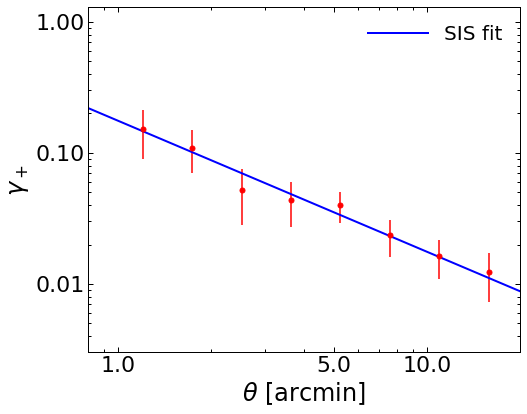

In [ ]:
# [Cell 4]
##############################
# Fitting the derived tangential shear profile with an SIS profile

# SIS shear profile
def fit_sis(x, t_ein):
    return 0.5 * (t_ein / x)

# fit parameter t_ein (Einstein radius) with observed shear profile
tein, cov = curve_fit(fit_sis, tbin, gt_ave, sigma = gt_sig)

# Output the best-fit Einstein radius
print(r'Einstein radius: %.2f arcmin' % tein[0])

# Compute the best-fit profile
tt1 = 10 ** np.linspace(-1.0, 2.0, num = 300)
yy1 = fit_sis(tt1, tein[0])

ofile = 'sis_'+cname+'.dat'
f1 = open(ofile, 'w')

for i in range(len(tt1)):
   f1.write('%f ' %(tt1[i]))
   f1.write('%f ' %(yy1[i]))
   f1.write('\n')

f1.close()
# Please remove a hash mark (#) below if you want to save the SIS profile into a .dat file
#files.download(ofile)

# Derive mass from the best-fit Einstein radius
tein_rad = tein[0] * u.arcmin
dos = cosmo.angular_diameter_distance(zs)
dol = cosmo.angular_diameter_distance(zl)
dls = cosmo.angular_diameter_distance_z1z2(zl, zs)

##############################
# make a plot: gt fitted with SIS

xmin = 0.8
xmax = 20.0
ymin = 0.003
ymax = 1.3

plt.figure(figsize=(8,6))

plt.hlines(0, xmin, xmax, linestyles="dotted")

plt.plot(tt1, yy1, "-", color='b', lw = 2.)

plt.plot(tbin, gt_ave, ".", markersize = 10, color='r')
plt.errorbar(tbin, gt_ave, yerr = gt_sig, fmt = 'none', ecolor = 'r', label='_nolegend_')

plt.legend(["SIS fit"], markerscale=1, frameon=False, fontsize=20, labelspacing=0.3, numpoints=1, loc='upper right')

ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks([0.5,1,5,10])
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])

plt.xlabel('$\\theta$ [arcmin]',fontsize=24)
plt.ylabel('$\gamma_+$',fontsize=24)
plt.subplots_adjust(top=0.95)
plt.subplots_adjust(bottom=0.15)
plt.subplots_adjust(left=0.15)

plt.savefig("plot2_"+cname+".png", dpi=150, transparent=True)
# Please remove a hash mark (#) below if you want to save the plot into a png file
#files.download("plot2_"+cname+".png")

# Please remove a hash mark (#) below if you want to save the plot into a pdf file
#plt.savefig("plot2_"+cname+".pdf", bbox_inches = 'tight')
#files.download("plot2_"+cname+".pdf")

**The angular diameter distance respect to various cosmological models**

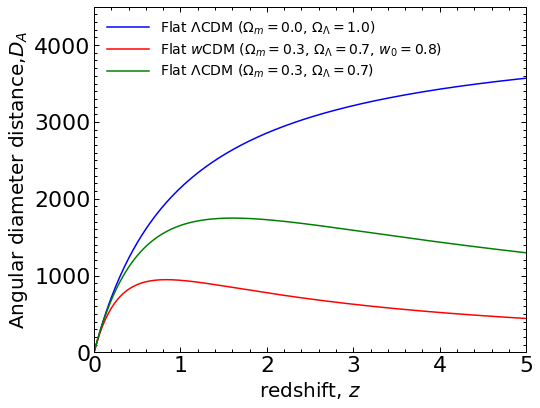

In [ ]:
###############################
# [Cell 4]
# Example for angular diameter distance by varying cosmological models and parameters
cosmo1 = FlatLambdaCDM(H0 = 70, Om0 = 0.00)
cosmo2 = FlatwCDM(H0 = 70, Om0 = 0.3, w0=0.8)
cosmo3 = FlatLambdaCDM(H0 = 70, Om0 = 0.30)
xmin = 0
xmax = 5
ymin = 0
ymax = 4500

plt.figure(figsize=(8,6))

zz = np.linspace(0.0, 5.0, num = 300)

distance1 = cosmo1.angular_diameter_distance(zz)
distance2 = cosmo2.angular_diameter_distance(zz)
distance3 = cosmo3.angular_diameter_distance(zz)

plt.plot(zz, distance1, markersize = 10, color = 'b')
plt.plot(zz, distance2, markersize = 10, color = 'r')
plt.plot(zz, distance3, markersize = 10, color = 'g')

plt.legend(["Flat $\Lambda$CDM ($\Omega_m=0.0$, $\Omega_{\Lambda}=1.0$)", "Flat $w$CDM ($\Omega_m=0.3$, $\Omega_{\Lambda}=0.7$, $w_0=0.8$)", "Flat $\Lambda$CDM ($\Omega_m=0.3$, $\Omega_{\Lambda}=0.7$)"], markerscale=1, frameon=False, fontsize=14, labelspacing=0.3, numpoints=1, loc='upper left')

ax = plt.gca()
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(100))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.2))

plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])

plt.ylabel('Angular diameter distance,$D_A$',fontsize=20)
plt.xlabel('redshift, $z$',fontsize=20)
plt.subplots_adjust(top=0.95)
plt.subplots_adjust(bottom=0.15)
plt.subplots_adjust(left=0.15)

plt.savefig("DA.png", dpi=150, transparent=True)
# Please remove a hash mark (#) below if you want to save the plot into a png file
#files.download("DA.png")

# Please remove a hash mark (#) below if you want to save the plot into a pdf file
#plt.savefig("DA.pdf", bbox_inches = 'tight')
#files.download("DA.pdf")

**Navarro-Frenk-White (NFW) density profile**



R_200: 1.17 Mpc
M_200: 25.78e14 M_sun/h
c_200: 1.89


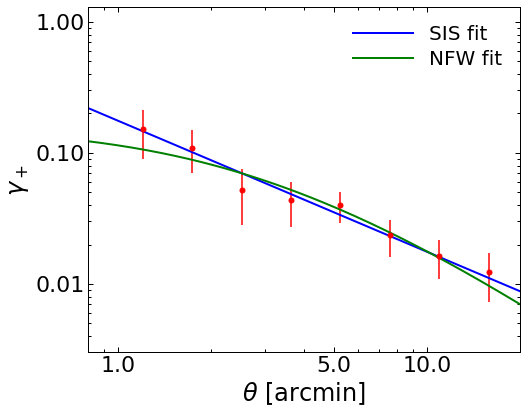

In [ ]:
######################################
# [Cell 6]
# fitting with NFW profile
# Please be careful when you fit NFW for sdss0915!
def arcsec(z):
    """Compute the inverse sec of the complex number z."""
    f1 = 1j / z
    f2 = sm.sqrt(1.0 - 1.0 / (z * z))
    f3 = 1j * np.log(f1 + f2)
    return 0.5 * np.pi + f3

def fit_nfw(x, rs, fac):
    """Compute the surface mass density minus its mean at radius r."""
    xx = x / rs
    f1 = 1.0 / (1.0 - (xx * xx))
    f2 = ((3.0 * (xx * xx)) - 2.0) * arcsec(xx)
    f3 = (xx * xx) * (sm.sqrt(xx * xx - 1.0))**3
    f4 = (f2 / f3).real
    f5 = 2.0 * np.log(xx / 2.0) / (xx * xx)
    return fac * (f1 + f4 + f5)

def mean_density_zero(x):
    Delta = 200
    rho_c = (cosmo.critical_density(zl).to(u.Msun/u.Mpc**3)).value
    xx = x / rs
    Fac = (fac * (const.c **2. / (4.0 * np.pi * const.G)).to(u.Msun/u.Mpc) * dos /dol /dls).value
    mean_density = 3 * (1 / xx)**3 * (Fac/(2*rs)) * (np.log((1 + xx)) - xx / (1 + xx))
    return  mean_density - Delta * rho_c

def mass(x):
    Delta = 200
    xx = x / rs
    rho_c = (cosmo.critical_density(zl).to(u.Msun/u.Mpc**3)).value
    Fac = (fac * (const.c **2. / (4.0 * np.pi * const.G)).to(u.Msun/u.Mpc) * dos /dol /dls).value
    return 4 * np.pi * (Fac/(2*rs)) * rs**3 * (np.log((1 + xx)) - xx / (1 + xx))

p, cov = curve_fit(fit_nfw, tbin, gt_ave, sigma = gt_sig)

tt2 = 10 ** np.linspace(-1.0, 2.0, num = 300)
yy2 = fit_nfw(tt2, p[0], p[1])

rs=p[0]
fac=p[1]

r200 = (brentq(mean_density_zero, 1e-6, 20)*u.arcmin*(cosmo.kpc_proper_per_arcmin(zl)/1000)).value
print('R_200: %.2f Mpc' % r200)
M200= mass(r200)/1e14/(cosmo.H0/100).value
print('M_200: %.2fe14 M_sun/h' % M200)
c200=brentq(mean_density_zero, 1e-6, 20)/rs
print('c_200: %.2f' % c200)

ofile = 'nfw_'+cname+'.dat'
f1 = open(ofile, 'w')

for i in range(len(tt2)):
   f1.write('%f ' %(tt2[i]))
   f1.write('%f ' %(yy2[i]))
   f1.write('\n')

f1.close()
# Please remove a hash mark (#) below if you want to save the NFW profile into a .dat file
#files.download(ofile)

xmin = 0.8
xmax = 20.0
ymin = 0.003
ymax = 1.3

plt.figure(figsize=(8,6))

plt.hlines(0, xmin, xmax, linestyles="dotted")

plt.plot(tt1, yy1, "-", color='b', lw = 2.)
plt.plot(tt2, yy2, "-", color='g', lw = 2.)

plt.plot(tbin, gt_ave, ".", markersize = 10, color='r')
plt.errorbar(tbin, gt_ave, yerr = gt_sig, fmt = 'none', ecolor = 'r', label='_nolegend_')

plt.legend(["SIS fit","NFW fit"], markerscale=1, frameon=False, fontsize=20, labelspacing=0.3, numpoints=1, loc='upper right')

ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks([0.5,1,5,10])
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])

plt.xlabel('$\\theta$ [arcmin]',fontsize=24)
plt.ylabel('$\gamma_+$',fontsize=24)
plt.subplots_adjust(top=0.95)
plt.subplots_adjust(bottom=0.15)
plt.subplots_adjust(left=0.15)

plt.savefig("plot3_"+cname+".png", dpi=150, transparent=True)
# Please remove a hash mark (#) below if you want to save the plot into a png file
#files.download("plot3_"+cname+".png")

# Please remove a hash mark (#) below if you want to save the plot into a pdf file
#plt.savefig("plot3_"+cname+".pdf", bbox_inches = 'tight')
#files.download("plot3_"+cname+".pdf")